# Atividade 07

Aluno: Luiz Guilherme Seleme Fofano<br>
Disciplina: HIML<br>

### O exercício 7 será realizado ao final desta cópia da atividade 05, a fim de comparar os resultados da rede neural com os demais métodos previamente aplicados

## 1 - Importação

In [1]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF

In [2]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [3]:
Nc

850

(8192, 850)


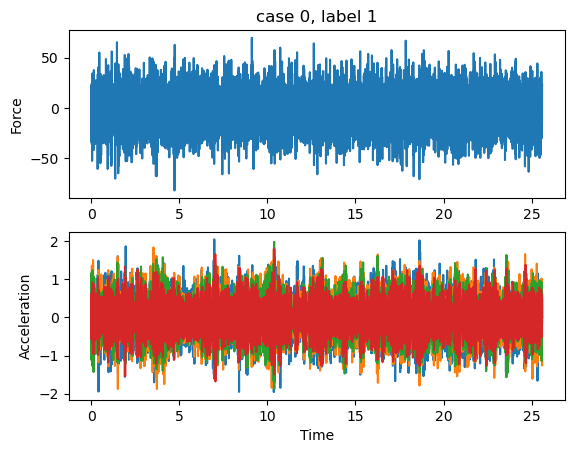

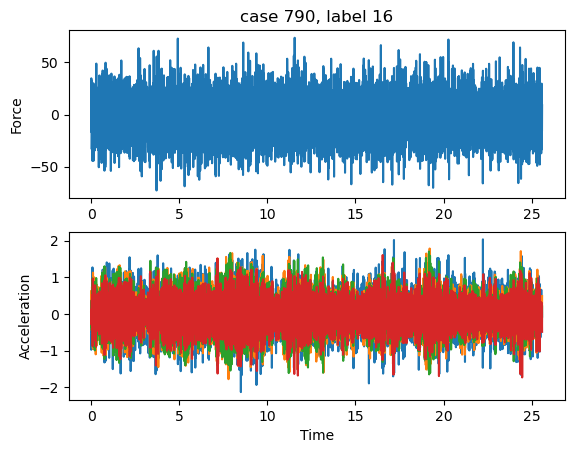

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
print(Ch1.shape)
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## 2 - AR

In [5]:
from statsmodels.tsa.ar_model import AutoReg

In [6]:
channels = [Ch2, Ch3, Ch4, Ch5]
AR = []
order = 29 # para ficar com 30 colunas por canal (n+1)

for channel in channels:
    exp = []
    for case in range(Nc):
        reg = AutoReg(channel[:,case],lags=order).fit()
        exp.append(reg.params)
    exp = np.vstack(exp)
    AR.append(exp)

X1 = np.hstack(AR)       

In [7]:
X1.shape

(850, 120)

## 3 - Preparando os Dados

Com base na atividade 2, percebeu-se que o melhor modelo em termos de predição foi o SoftMax ajustado ao conjunto X2_sc (X2 após normalização de X1), que para este caso também será normalizado.

Dessa forma, vamos dividir o conjunto X1 normalizado entre treinamento (60%) e teste (40%), fitar o PCA apenas no conjunto de treinamento, antes de transformar o conjunto inteiro, re-normalizar os conjuntos de teste e treino pós-PCA e então fazer a busca dos hiper-parâmetros para regressão logística, SVC e KNN.

Para a atividade 05 serão testados também RandomForest e DecisionTree

[0.37585014 0.22279748 0.10121232 0.08300921 0.05197382 0.03813015
 0.03673931 0.02504004 0.01399312 0.01232693]


São necessários 10 componentes para atingir uma variância explicada de 0.9610725174870598 (>95%)


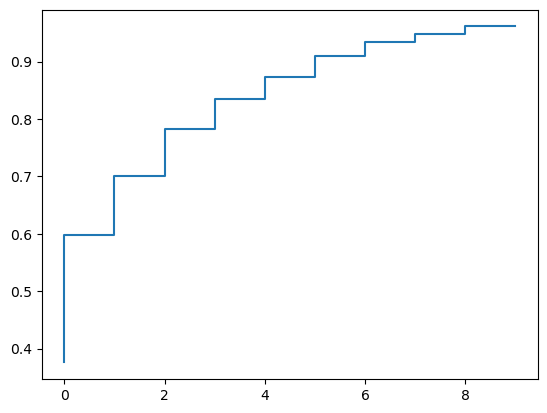

In [8]:
# Normalização
rand = 1009

scaler = MinMaxScaler(feature_range=(-1,1))
X1_sc = scaler.fit(X1).transform(X1)


# Divisão em grupo de treinamento e teste

X1_tr, X1_te, y_tr, y_te = train_test_split(X1_sc, y,random_state=rand,test_size=0.4)


# Aplicação do PCA e re-normalização

pca = PCA(n_components = 0.95)
pca.fit(X1_tr)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
print(exp_var)
plt.step(range(0,len(cum_var)),cum_var,label='Cumulative variance')
print(f'\n\nSão necessários {len(exp_var)} componentes para atingir uma variância explicada de {cum_var[-1]} (>95%)')

X1_tr_pca = pca.transform(X1_tr)
X1_te_pca = pca.transform(X1_te)

X1_tr_pca_norm = scaler.fit(X1_tr_pca).transform(X1_tr_pca)
X1_te_pca_norm = scaler.fit(X1_tr_pca).transform(X1_te_pca)


## 4 - Rodada com configuração default

### 4.1 - Softmax

In [9]:
y_def = []
score_def = []

logreg = LogisticRegression(multi_class='multinomial',random_state=rand,max_iter=10000).fit(X1_tr_pca_norm, y_tr)

score_train = logreg.score(X1_tr_pca_norm, y_tr)
score_test = logreg.score(X1_te_pca_norm, y_te)

print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')

y_def.append(logreg.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 0.9901960784313726
Score de teste: 0.9823529411764705


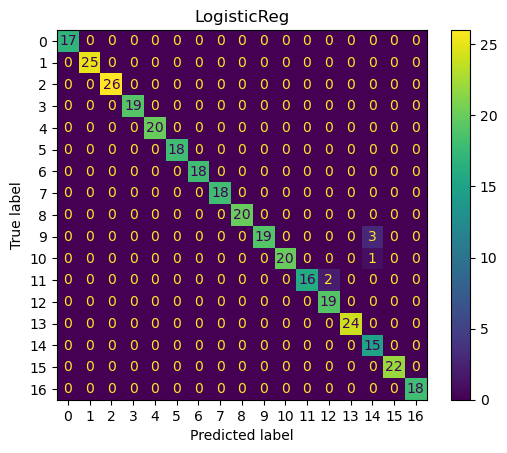

In [10]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, logreg.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('LogisticReg')
cmgraph.plot(ax=ax)

### 4.2 - SVC

In [11]:
# SVC

svm = SVC(random_state=rand).fit(X1_tr_pca_norm,y_tr)
score_train = svm.score(X1_tr_pca_norm,y_tr)
score_test = svm.score(X1_te_pca_norm,y_te)

         
print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')

y_def.append(svm.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 0.996078431372549
Score de teste: 0.9941176470588236


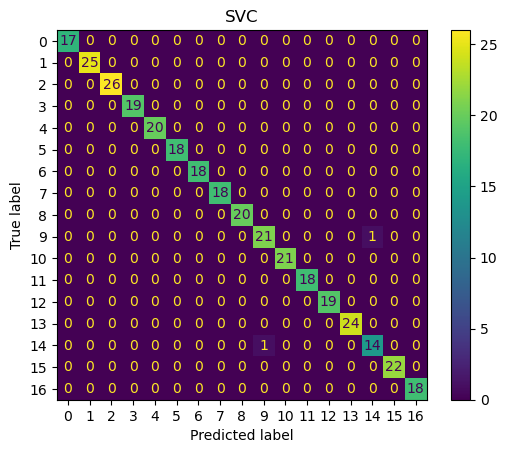

In [12]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, svm.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('SVC')
cmgraph.plot(ax=ax)

### 4.3 - KNN

In [13]:
knn = KNN().fit(X1_tr_pca_norm,y_tr)
score_train = knn.score(X1_tr_pca_norm,y_tr)
score_test = knn.score(X1_te_pca_norm,y_te)

print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')  

y_def.append(knn.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 0.9921568627450981
Score de teste: 0.9852941176470589


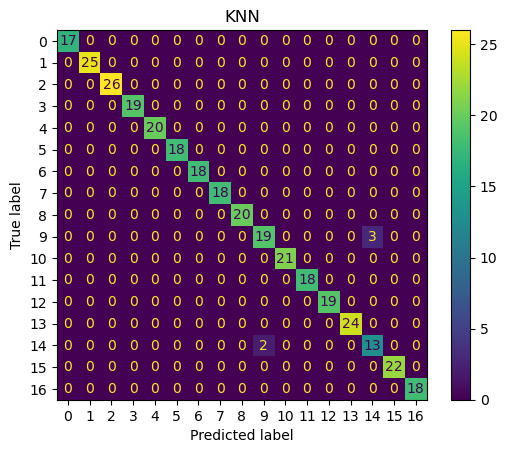

In [14]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, knn.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('KNN')
cmgraph.plot(ax=ax)

## 4.4 - DecisionTree

In [15]:
DecT = DT(random_state=rand).fit(X1_tr_pca_norm,y_tr)
score_train = DecT.score(X1_tr_pca_norm,y_tr)
score_test = DecT.score(X1_te_pca_norm,y_te)

print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')  

y_def.append(DecT.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 1.0
Score de teste: 0.9470588235294117


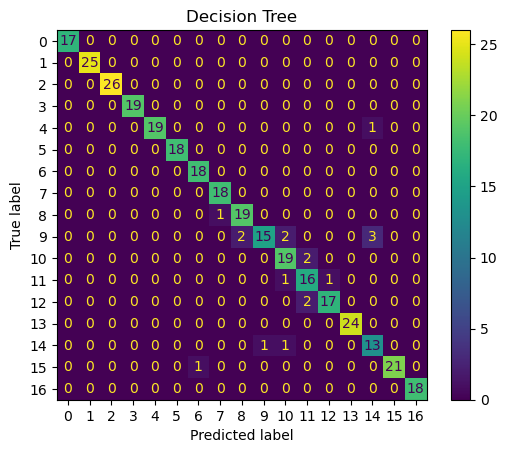

In [16]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, DecT.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('Decision Tree')
cmgraph.plot(ax=ax)

## 4.5 - Random Forest

In [17]:
ranf = RF(random_state=rand).fit(X1_tr_pca_norm,y_tr)
score_train = ranf.score(X1_tr_pca_norm,y_tr)
score_test = ranf.score(X1_te_pca_norm,y_te)

print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')  

y_def.append(ranf.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 1.0
Score de teste: 0.9794117647058823


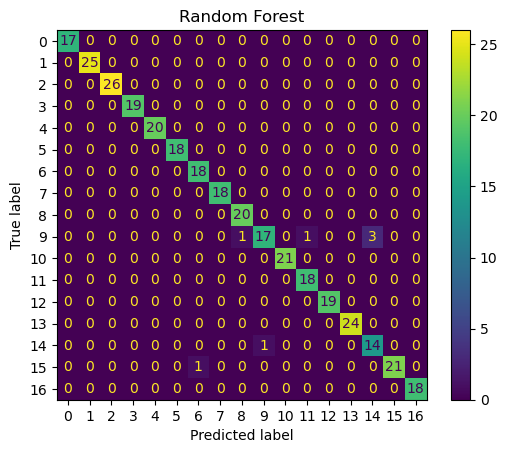

In [18]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, ranf.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('Random Forest')
cmgraph.plot(ax=ax)

## 5 -  Hyperparameter Tuning

Serão avaliados os mesmos parâmetros testados na atividade 03 para melhorar a comparação:<br><br>
**SVC** <br>
* kernel <br>
* C <br>
* degree (para o caso poly) <br><br>

**KNN** <br>
* weights <br>
* neighbors <br><br>

**LogReg** - hava considerado apenas o default, para esse caso vou avaliar <br>
* C <br>
* solver <br><br>

Além disso, para a DecisionTree e RandomForest serão avaliados:<br><br>
**DT**<br>
* splitter
* criterion
* max_depth
* min_samples_split
* min_samples_leaf
* max_features
* max_leaf_nodes

**RF**
* n_estimators
* criterion'
* max_depth
* min_samples_split
* min_samples_leaf
* max_features
* max_leaf_nodes

In [19]:
models = [("LogReg",LogisticRegression(multi_class='multinomial', max_iter=5000, random_state=rand)),
          ("SVC",SVC(random_state=rand)),
          ("KNN",KNN()),
          ("DecisionTree",DT(random_state=rand)),
          ("RandomForest",RF(random_state=rand))
         ]

params = [[{"C":stats.loguniform(0.001,1000),
           "solver":['lbfgs', 'liblinear', 'newton-cg', 'sag']}],
          
          [{"kernel":["linear","poly","rbf","sigmoid"],
           "C":stats.loguniform(0.001,1000),
           "degree":[2,3,4,5]}],
          
          [{"weights":["uniform","distance"],
           "n_neighbors":stats.randint(2,100)}],
          
          [{"splitter":['best', 'random'],
           "criterion":['gini', 'entropy'],
           "max_depth":stats.randint(2,50),
           "min_samples_split":stats.randint(2,25),
           "min_samples_leaf":stats.randint(1,25),
           "max_features":["sqrt","log2"],
           "max_leaf_nodes":stats.randint(17,100)}],
          
          [{"n_estimators":stats.randint(50,250),
           "criterion":['gini', 'entropy'],
           "max_depth":stats.randint(2,50),
           "min_samples_split":stats.randint(2,25),
           "min_samples_leaf":stats.randint(1,25),
           "max_features":["sqrt","log2"],
           "max_leaf_nodes":stats.randint(17,100)}]
          
         ]

best_params = []

rkf = RepeatedKFold(n_splits=5,n_repeats=50,random_state=rand)

for k in range(len(models)):
    random_search = RandomizedSearchCV(models[k][1],verbose=0,scoring='accuracy',n_iter=100,n_jobs=-1,cv=rkf,param_distributions=params[k],random_state=rand)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        random_search.fit(X1_tr_pca_norm,y_tr)

        yh_test = random_search.predict(X1_te_pca_norm)

        score_train = random_search.score(X1_tr_pca_norm,y_tr)
        score_test = random_search.score(X1_te_pca_norm,y_te)

        print(f'\n\n{models[k][0]}:\n')
        print(f'Score de treino: {score_train}')
        print(f'Score de teste: {score_test}')
        print('Melhor ajuste:')
        for par in random_search.best_params_.keys():
            print('        Parâmetro {}: {}'.format(par, random_search.best_params_[par]))  
        print()
        print(f'O score do ajuste Default foi de {score_def[k]}')
        print(f'O ganho de acurácia com o tuning foi de {score_test-score_def[k]}')
        
        best_params.append(yh_test)
        



LogReg:

Score de treino: 0.9921568627450981
Score de teste: 0.9941176470588236
Melhor ajuste:
        Parâmetro C: 4.889693952970885
        Parâmetro solver: lbfgs

O score do ajuste Default foi de 0.9823529411764705
O ganho de acurácia com o tuning foi de 0.01176470588235301


SVC:

Score de treino: 0.9941176470588236
Score de teste: 0.9970588235294118
Melhor ajuste:
        Parâmetro C: 1.7365454195002712
        Parâmetro degree: 3
        Parâmetro kernel: linear

O score do ajuste Default foi de 0.9941176470588236
O ganho de acurácia com o tuning foi de 0.002941176470588225


KNN:

Score de treino: 1.0
Score de teste: 0.9941176470588236
Melhor ajuste:
        Parâmetro n_neighbors: 10
        Parâmetro weights: distance

O score do ajuste Default foi de 0.9852941176470589
O ganho de acurácia com o tuning foi de 0.008823529411764675


DecisionTree:

Score de treino: 0.9725490196078431
Score de teste: 0.888235294117647
Melhor ajuste:
        Parâmetro criterion: gini
        Par

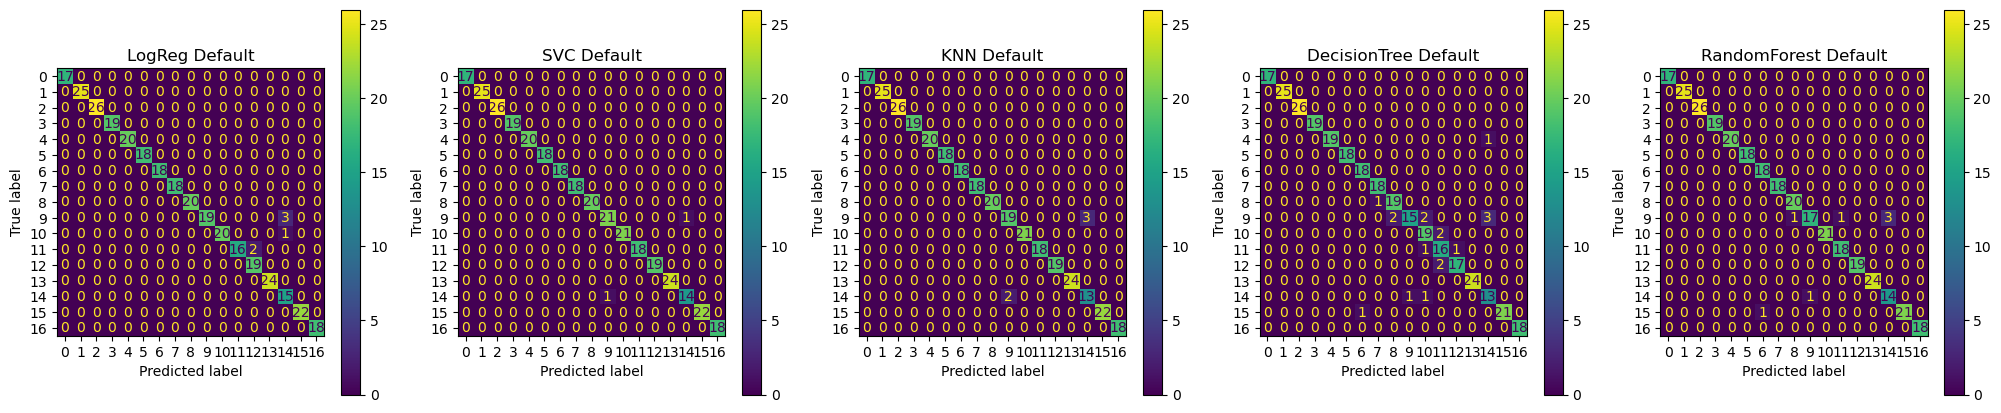

In [20]:
fig, axs = plt.subplots(ncols=len(models),nrows=1,figsize=[5*len(models),5])


i = 0
for ax in axs:
    cm = confusion_matrix(y_te, y_def[i])
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(f'{models[i][0]} Default')
    cmgraph.plot(ax=ax)
    
    i = i+1


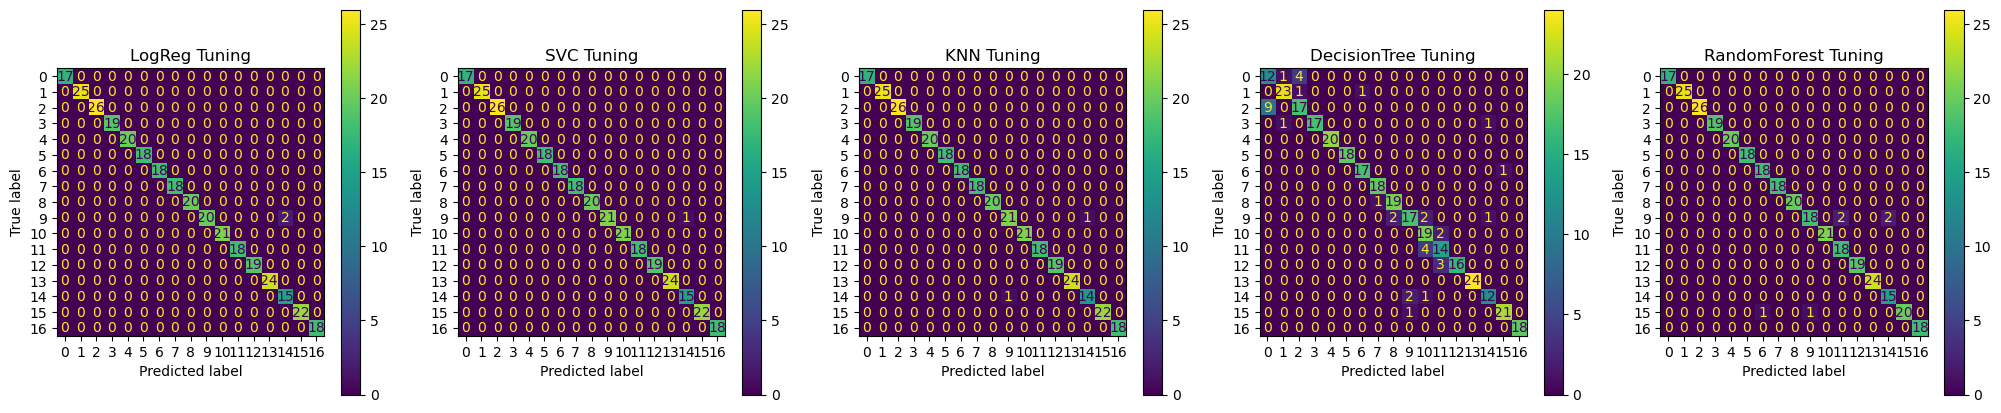

In [21]:
fig, axs = plt.subplots(ncols=len(models),nrows=1,figsize=[5*len(models),5])


i = 0
for ax in axs:
    cm1 = confusion_matrix(y_te, best_params[i])
    cmgraph1 = ConfusionMatrixDisplay(cm1)
    ax.set_title(f'{models[i][0]} Tuning')
    cmgraph1.plot(ax=ax)

    
    i = i+1

## 6 - Conclusões da Atividade05

Pode-se perceber que a utilização do tuning de hiper-parâmetros de fato contribuiu para aumentar a acurácia dos modelos, ainda que o resultado com as configurações default já estivesse bem alto (> 0.95).<br>
Da análise dos resultados do Decision Tree e Random Forest, podemos perceber a importância de definir bem os ranges de busca dos hiper-parâmetros, dado que o modelo com tuning do Decision Tree acabou tendo uma pequena redução de score em relação ao Default. Destaca-se, portanto, a importâcia de se conhecer bem o problema, ranges e ferramentas de forma a garantir o melhor resultado sempre.

## 7 - Importação bibliotecas para rede neural e definição inicial

In [74]:
import tensorflow as tf

X1_tr_pca_norm.shape

(510, 10)

In [120]:
model = tf.keras.models.Sequential([
tf.keras.layers.InputLayer(input_shape=[10], name='Inputs'), 
tf.keras.layers.Dense(100, activation="relu", name='Camada01'),
tf.keras.layers.Dense(17, name='Output'),
])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.summary()

score_def = []
y_nn_def = []

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(X1_tr_pca_norm, y_tr-1, epochs=6,validation_split = 0.2, callbacks=[callback])

score = model.evaluate(X1_te_pca_norm, y_te-1)[1]

y_nn_def.append(model.predict(X1_te_pca_norm))
score_def.append(score)

print(f'\n\nO score de teste da rede foi de {score}')


Model: "sequential_431"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Camada01 (Dense)            (None, 100)               1100      
                                                                 
 Output (Dense)              (None, 17)                1717      
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
13/13 [==============================] - 1s 16ms/step - loss: 2.7913 - sparse_categorical_accuracy: 0.1789 - val_loss: 2.6909 - val_sparse_categorical_accuracy: 0.2941
Epoch 2/6
13/13 [==============================] - 0s 8ms/step - loss: 2.6380 - sparse_categorical_accuracy: 0.3725 - val_loss: 2.5614 - val_sparse_categorical_accuracy: 0.5196
Epoch 3/6
13/13 [==============================] - 0s 7ms/s

## 7.1 - Testando número de neurônios e epochs

In [121]:
epoch = [50]
nodes = [10,50,100,200]
best_score = 0
loss = 1000
loss_val = 1000
epochs = 0
node = 0
best_score_val = 0

for ep in epoch:
    for nod in nodes:
        model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=[10], name='Inputs'), 
        tf.keras.layers.Dense(nod, activation="relu", name='Camada01'),
        tf.keras.layers.Dense(17, name='Output'),
        ])

        model.summary()


        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )

        mf = model.fit(X1_tr_pca_norm, y_tr-1, epochs=ep, validation_split = 0.2, callbacks=[callback])
        
        if mf.history["val_sparse_categorical_accuracy"][-1] >= best_score_val:
            if mf.history["val_loss"][-1] < loss_val and mf.history["loss"][-1] < loss:
            #if mf.history["loss"][-1] < loss:
                loss = mf.history["loss"][-1]
                loss_val = mf.history["val_loss"][-1]
                best_score_val = mf.history["val_sparse_categorical_accuracy"][-1]
                epochs = len(mf.history['loss'])
                node = nod
                best_model = model.predict(X1_te_pca_norm)
                best_score = model.evaluate(X1_te_pca_norm, y_te-1)[1]


Model: "sequential_432"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Camada01 (Dense)            (None, 10)                110       
                                                                 
 Output (Dense)              (None, 17)                187       
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
13/13 [==============================] - 1s 16ms/step - loss: 2.8866 - sparse_categorical_accuracy: 0.1078 - val_loss: 2.8410 - val_sparse_categorical_accuracy: 0.1569
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 2.8476 - sparse_categorical_accuracy: 0.1225 - val_loss: 2.8094 - val_sparse_categorical_accuracy: 0.1667
Epoch 3/50
13/13 [==============================] - 0s 8ms/st

Epoch 43/50
13/13 [==============================] - 0s 8ms/step - loss: 1.1541 - sparse_categorical_accuracy: 0.8407 - val_loss: 1.2208 - val_sparse_categorical_accuracy: 0.8039
Epoch 44/50
13/13 [==============================] - 0s 9ms/step - loss: 1.1188 - sparse_categorical_accuracy: 0.8578 - val_loss: 1.1864 - val_sparse_categorical_accuracy: 0.8235
Epoch 45/50
13/13 [==============================] - 0s 8ms/step - loss: 1.0830 - sparse_categorical_accuracy: 0.8799 - val_loss: 1.1517 - val_sparse_categorical_accuracy: 0.8333
Epoch 46/50
13/13 [==============================] - 0s 8ms/step - loss: 1.0489 - sparse_categorical_accuracy: 0.8824 - val_loss: 1.1182 - val_sparse_categorical_accuracy: 0.8529
Epoch 47/50
13/13 [==============================] - 0s 8ms/step - loss: 1.0158 - sparse_categorical_accuracy: 0.8946 - val_loss: 1.0844 - val_sparse_categorical_accuracy: 0.8627
Epoch 48/50
13/13 [==============================] - 0s 8ms/step - loss: 0.9838 - sparse_categorical_accu

Epoch 34/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2918 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.3117 - val_sparse_categorical_accuracy: 0.9706
Epoch 35/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2776 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.9706
Epoch 36/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.2836 - val_sparse_categorical_accuracy: 0.9706
Epoch 37/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2524 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.2721 - val_sparse_categorical_accuracy: 0.9706
Epoch 38/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2412 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.2609 - val_sparse_categorical_accuracy: 0.9706
Epoch 39/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2307 - sparse_categorical_accu

Epoch 25/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2499 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2791 - val_sparse_categorical_accuracy: 0.9706
Epoch 26/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2338 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2616 - val_sparse_categorical_accuracy: 0.9706
Epoch 27/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2191 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.2469 - val_sparse_categorical_accuracy: 0.9706
Epoch 28/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2061 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2347 - val_sparse_categorical_accuracy: 0.9804
Epoch 29/50
13/13 [==============================] - 0s 7ms/step - loss: 0.1947 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2218 - val_sparse_categorical_accuracy: 0.9804
Epoch 30/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1842 - sparse_categorical_accu

Epoch 16/50
13/13 [==============================] - 0s 9ms/step - loss: 0.3067 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.3299 - val_sparse_categorical_accuracy: 0.9804
Epoch 17/50
13/13 [==============================] - 0s 9ms/step - loss: 0.2744 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2945 - val_sparse_categorical_accuracy: 0.9804
Epoch 18/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2478 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.2726 - val_sparse_categorical_accuracy: 0.9804
Epoch 19/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2252 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.2472 - val_sparse_categorical_accuracy: 0.9804
Epoch 20/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2263 - val_sparse_categorical_accuracy: 0.9804
Epoch 21/50
13/13 [==============================] - 0s 7ms/step - loss: 0.1904 - sparse_categorical_accu

In [122]:

print(f'O score de validação do melhor ajuste foi de {best_score_val}\n\nA configuração da melhor rede foi:\n\n{epochs} epoch\n{node} nodes')

print(f'O score de teste com essa rede foi de {best_score}')


O score de validação do melhor ajuste foi de 0.9803921580314636

A configuração da melhor rede foi:

50 epoch
200 nodes
O score de teste com essa rede foi de 0.9941176176071167


## 7.2 - Testando mais Layers

Como última análise, será avaliada a adição de layers para ver qual o ganho

In [123]:
model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=[10], name='Inputs'), 
            tf.keras.layers.Dense(100, activation="relu", name='Camada01'),
            tf.keras.layers.Dense(100, activation="relu", name='Camada02'),
            tf.keras.layers.Dense(17, name='Output'),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(X1_tr_pca_norm, y_tr-1, epochs=6,validation_split = 0.2, callbacks=[callback])

y_nn_def.append(model.predict(X1_te_pca_norm))
score_def.append(model.evaluate(X1_te_pca_norm, y_te-1)[1])
scorew = score_def[-1]

print(f'\n\nO score de teste da rede inicial com 2 Layers (6 epoch e 100 nodes) foi de {scorew}')

Model: "sequential_436"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Camada01 (Dense)            (None, 100)               1100      
                                                                 
 Camada02 (Dense)            (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 17)                1717      
                                                                 
Total params: 12917 (50.46 KB)
Trainable params: 12917 (50.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
13/13 [==============================] - 1s 17ms/step - loss: 2.7429 - sparse_categorical_accuracy: 0.1863 - val_loss: 2.6376 - val_sparse_categorical_accuracy: 0.4804
Epoch 2/6
13/13 [==============================] - 0s 7ms/step - loss: 2.5006 - sparse_categorical_acc

In [124]:
epoch = [50]
nodes = [10,50,100,200]
best_score2 = 0
epochs2 = 0
node2 = 0
node22 = 0
loss2 = 1000
loss_val2 = 1000
best_score_val2 = 0

for ep in epoch:
    for nod in nodes:
        for nod2 in nodes:
            model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=[10], name='Inputs'), 
            tf.keras.layers.Dense(nod, activation="relu", name='Camada01'),
            tf.keras.layers.Dense(nod2, activation="relu", name='Camada02'),
            tf.keras.layers.Dense(17, name='Output'),
            ])

            model.summary()


            model.compile(
                optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
            )

            mf = model.fit(X1_tr_pca_norm, y_tr-1, epochs=ep, validation_split = 0.2, callbacks=[callback])
                
            if mf.history["val_sparse_categorical_accuracy"][-1] >= best_score_val2:
                if mf.history["val_loss"][-1] < loss_val2 and mf.history["loss"][-1] < loss2:
                #if mf.history["loss"][-1] < loss2:
                    loss2 = mf.history["loss"][-1]
                    loss_val2 = mf.history["val_loss"][-1]
                    best_score_val2 = mf.history["val_sparse_categorical_accuracy"][-1]
                    epochs2 = len(mf.history['loss'])
                    node2 = nod
                    node22 = nod2
                    best_model2 = model.predict(X1_te_pca_norm)
                    best_score2 = model.evaluate(X1_te_pca_norm, y_te-1)[1]              

Model: "sequential_437"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Camada01 (Dense)            (None, 10)                110       
                                                                 
 Camada02 (Dense)            (None, 10)                110       
                                                                 
 Output (Dense)              (None, 17)                187       
                                                                 
Total params: 407 (1.59 KB)
Trainable params: 407 (1.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
13/13 [==============================] - 1s 16ms/step - loss: 2.7961 - sparse_categorical_accuracy: 0.0588 - val_loss: 2.7616 - val_sparse_categorical_accuracy: 0.0784
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 2.7705 - sparse_categorical_accurac

13/13 [==============================] - 0s 8ms/step - loss: 0.5581 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.6387 - val_sparse_categorical_accuracy: 0.9020
Epoch 43/50
13/13 [==============================] - 0s 8ms/step - loss: 0.5238 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.6024 - val_sparse_categorical_accuracy: 0.9118
Epoch 44/50
13/13 [==============================] - 0s 8ms/step - loss: 0.4924 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.5685 - val_sparse_categorical_accuracy: 0.9118
Epoch 45/50
13/13 [==============================] - 0s 7ms/step - loss: 0.4632 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.5401 - val_sparse_categorical_accuracy: 0.9216
Epoch 46/50
13/13 [==============================] - 0s 7ms/step - loss: 0.4366 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.5100 - val_sparse_categorical_accuracy: 0.9216
Epoch 47/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4103 - sparse_categorical_accuracy: 0.9706

13/13 [==============================] - 0s 8ms/step - loss: 0.3220 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.3874 - val_sparse_categorical_accuracy: 0.9216
Epoch 33/50
13/13 [==============================] - 0s 9ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.3627 - val_sparse_categorical_accuracy: 0.9216
Epoch 34/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.3459 - val_sparse_categorical_accuracy: 0.9412
Epoch 35/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.3299 - val_sparse_categorical_accuracy: 0.9314
Epoch 36/50
13/13 [==============================] - 0s 9ms/step - loss: 0.2523 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.3158 - val_sparse_categorical_accuracy: 0.9118
Epoch 37/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2373 - sparse_categorical_accuracy: 0.9657

13/13 [==============================] - 0s 8ms/step - loss: 0.2881 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.9902
Epoch 23/50
13/13 [==============================] - 0s 9ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.2815 - val_sparse_categorical_accuracy: 0.9902
Epoch 24/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2341 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.2497 - val_sparse_categorical_accuracy: 0.9902
Epoch 25/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2111 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2308 - val_sparse_categorical_accuracy: 0.9902
Epoch 26/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2102 - val_sparse_categorical_accuracy: 0.9902
Epoch 27/50
13/13 [==============================] - 0s 9ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.9902

13/13 [==============================] - 0s 8ms/step - loss: 0.6839 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.9216
Epoch 13/50
13/13 [==============================] - 0s 9ms/step - loss: 0.5815 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.6257 - val_sparse_categorical_accuracy: 0.9314
Epoch 14/50
13/13 [==============================] - 0s 8ms/step - loss: 0.5018 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.5464 - val_sparse_categorical_accuracy: 0.9314
Epoch 15/50
13/13 [==============================] - 0s 9ms/step - loss: 0.4378 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.4799 - val_sparse_categorical_accuracy: 0.9314
Epoch 16/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3837 - sparse_categorical_accuracy: 0.9534 - val_loss: 0.4195 - val_sparse_categorical_accuracy: 0.9412
Epoch 17/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3364 - sparse_categorical_accuracy: 0.9608

13/13 [==============================] - 0s 7ms/step - loss: 2.6820 - sparse_categorical_accuracy: 0.2328 - val_loss: 2.7015 - val_sparse_categorical_accuracy: 0.2647
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 2.6150 - sparse_categorical_accuracy: 0.3039 - val_loss: 2.6407 - val_sparse_categorical_accuracy: 0.2843
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 2.5340 - sparse_categorical_accuracy: 0.3529 - val_loss: 2.5703 - val_sparse_categorical_accuracy: 0.3333
Epoch 6/50
13/13 [==============================] - 0s 8ms/step - loss: 2.4390 - sparse_categorical_accuracy: 0.3848 - val_loss: 2.4883 - val_sparse_categorical_accuracy: 0.3235
Epoch 7/50
13/13 [==============================] - 0s 8ms/step - loss: 2.3286 - sparse_categorical_accuracy: 0.4093 - val_loss: 2.3906 - val_sparse_categorical_accuracy: 0.3725
Epoch 8/50
13/13 [==============================] - 0s 8ms/step - loss: 2.2026 - sparse_categorical_accuracy: 0.4706 - va

Epoch 49/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0867 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.1000 - val_sparse_categorical_accuracy: 0.9902
Epoch 50/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0959 - val_sparse_categorical_accuracy: 0.9902
Model: "sequential_442"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Camada01 (Dense)            (None, 50)                550       
                                                                 
 Camada02 (Dense)            (None, 50)                2550      
                                                                 
 Output (Dense)              (None, 17)                867       
                                                                 
Total params: 3967 (15.50 KB)
Trainable params: 3967 (15.50 KB)
Non-trainable params: 0 (0

13/13 [==============================] - 0s 8ms/step - loss: 0.0435 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0720 - val_sparse_categorical_accuracy: 0.9804
Epoch 41/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0709 - val_sparse_categorical_accuracy: 0.9804
Epoch 42/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0680 - val_sparse_categorical_accuracy: 0.9804
Epoch 43/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0386 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0689 - val_sparse_categorical_accuracy: 0.9804
Epoch 44/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0377 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0664 - val_sparse_categorical_accuracy: 0.9804
Epoch 45/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9951

13/13 [==============================] - 0s 7ms/step - loss: 0.0489 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0708 - val_sparse_categorical_accuracy: 0.9804
Epoch 32/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0463 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0688 - val_sparse_categorical_accuracy: 0.9804
Epoch 33/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0678 - val_sparse_categorical_accuracy: 0.9804
Epoch 34/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0661 - val_sparse_categorical_accuracy: 0.9804
Epoch 35/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0661 - val_sparse_categorical_accuracy: 0.9902
Epoch 36/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9926

13/13 [==============================] - 0s 9ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0816 - val_sparse_categorical_accuracy: 0.9804
Epoch 22/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0554 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0800 - val_sparse_categorical_accuracy: 0.9804
Epoch 23/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0749 - val_sparse_categorical_accuracy: 0.9902
Epoch 24/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0473 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0744 - val_sparse_categorical_accuracy: 0.9902
Epoch 25/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0728 - val_sparse_categorical_accuracy: 0.9706
Epoch 26/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9877

13/13 [==============================] - 0s 7ms/step - loss: 1.5308 - sparse_categorical_accuracy: 0.7132 - val_loss: 1.5541 - val_sparse_categorical_accuracy: 0.7647
Epoch 12/50
13/13 [==============================] - 0s 8ms/step - loss: 1.3664 - sparse_categorical_accuracy: 0.7966 - val_loss: 1.3956 - val_sparse_categorical_accuracy: 0.8431
Epoch 13/50
13/13 [==============================] - 0s 8ms/step - loss: 1.2093 - sparse_categorical_accuracy: 0.8260 - val_loss: 1.2374 - val_sparse_categorical_accuracy: 0.8725
Epoch 14/50
13/13 [==============================] - 0s 9ms/step - loss: 1.0669 - sparse_categorical_accuracy: 0.8456 - val_loss: 1.0960 - val_sparse_categorical_accuracy: 0.8725
Epoch 15/50
13/13 [==============================] - 0s 8ms/step - loss: 0.9387 - sparse_categorical_accuracy: 0.8603 - val_loss: 0.9834 - val_sparse_categorical_accuracy: 0.9020
Epoch 16/50
13/13 [==============================] - 0s 8ms/step - loss: 0.8295 - sparse_categorical_accuracy: 0.8725

13/13 [==============================] - 0s 7ms/step - loss: 2.5974 - sparse_categorical_accuracy: 0.3358 - val_loss: 2.5303 - val_sparse_categorical_accuracy: 0.4020
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 2.3975 - sparse_categorical_accuracy: 0.5588 - val_loss: 2.3165 - val_sparse_categorical_accuracy: 0.5882
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 2.1494 - sparse_categorical_accuracy: 0.6716 - val_loss: 2.0535 - val_sparse_categorical_accuracy: 0.6863
Epoch 5/50
13/13 [==============================] - 0s 9ms/step - loss: 1.8475 - sparse_categorical_accuracy: 0.7770 - val_loss: 1.7372 - val_sparse_categorical_accuracy: 0.7941
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 1.5140 - sparse_categorical_accuracy: 0.8211 - val_loss: 1.4061 - val_sparse_categorical_accuracy: 0.8333
Epoch 7/50
13/13 [==============================] - 0s 9ms/step - loss: 1.1851 - sparse_categorical_accuracy: 0.8775 - va

Epoch 48/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0236 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0607 - val_sparse_categorical_accuracy: 0.9804
Epoch 49/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0600 - val_sparse_categorical_accuracy: 0.9804
Epoch 50/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0606 - val_sparse_categorical_accuracy: 0.9804
Model: "sequential_447"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Camada01 (Dense)            (None, 100)               1100      
                                                                 
 Camada02 (Dense)            (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 17)    

13/13 [==============================] - 0s 8ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0538 - val_sparse_categorical_accuracy: 0.9804
Epoch 40/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0536 - val_sparse_categorical_accuracy: 0.9902
Epoch 41/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0218 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0522 - val_sparse_categorical_accuracy: 0.9804
Epoch 42/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0204 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0527 - val_sparse_categorical_accuracy: 0.9902
Epoch 43/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0527 - val_sparse_categorical_accuracy: 0.9902
Epoch 44/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0204 - sparse_categorical_accuracy: 0.9951

13/13 [==============================] - 0s 9ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0589 - val_sparse_categorical_accuracy: 0.9804
Epoch 31/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0571 - val_sparse_categorical_accuracy: 0.9804
Epoch 32/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0187 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0573 - val_sparse_categorical_accuracy: 0.9804
Epoch 33/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0558 - val_sparse_categorical_accuracy: 0.9804
Epoch 34/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0178 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0576 - val_sparse_categorical_accuracy: 0.9804
Epoch 35/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9975

13/13 [==============================] - 0s 8ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.2420 - val_sparse_categorical_accuracy: 0.9804
Epoch 22/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.2189 - val_sparse_categorical_accuracy: 0.9706
Epoch 23/50
13/13 [==============================] - 0s 7ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.2002 - val_sparse_categorical_accuracy: 0.9706
Epoch 24/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.1827 - val_sparse_categorical_accuracy: 0.9706
Epoch 25/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1427 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.1705 - val_sparse_categorical_accuracy: 0.9804
Epoch 26/50
13/13 [==============================] - 0s 7ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.9853

13/13 [==============================] - 0s 9ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.2006 - val_sparse_categorical_accuracy: 0.9706
Epoch 13/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1572 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.1766 - val_sparse_categorical_accuracy: 0.9608
Epoch 14/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1368 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.1574 - val_sparse_categorical_accuracy: 0.9804
Epoch 15/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.1396 - val_sparse_categorical_accuracy: 0.9804
Epoch 16/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.1299 - val_sparse_categorical_accuracy: 0.9804
Epoch 17/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0965 - sparse_categorical_accuracy: 0.9926

13/13 [==============================] - 0s 8ms/step - loss: 2.0055 - sparse_categorical_accuracy: 0.7402 - val_loss: 1.8908 - val_sparse_categorical_accuracy: 0.7059
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 1.5206 - sparse_categorical_accuracy: 0.8186 - val_loss: 1.4172 - val_sparse_categorical_accuracy: 0.7745
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 1.0334 - sparse_categorical_accuracy: 0.8578 - val_loss: 0.9663 - val_sparse_categorical_accuracy: 0.8529
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.6664 - sparse_categorical_accuracy: 0.8922 - val_loss: 0.6261 - val_sparse_categorical_accuracy: 0.9020
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.4286 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.4230 - val_sparse_categorical_accuracy: 0.9608
Epoch 8/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2983 - sparse_categorical_accuracy: 0.9583 - va

Epoch 49/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0572 - val_sparse_categorical_accuracy: 0.9804
Epoch 50/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0579 - val_sparse_categorical_accuracy: 0.9804
Model: "sequential_452"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Camada01 (Dense)            (None, 200)               2200      
                                                                 
 Camada02 (Dense)            (None, 200)               40200     
                                                                 
 Output (Dense)              (None, 17)                3417      
                                                                 
Total params: 45817 (178.97 KB)
Trainable params: 45817 (178.97 KB)
Non-trainable params: 

In [125]:

print(f'O score de validação da melhor rede com 2 hidden layers foi de {best_score_val2}\n\nA configuração da melhor rede foi:\n\n{epochs2} epoch\n{node2} nodes na primeira camada\n{node22} nodes na segunda camada')
print(f'\n\nO score de teste com essa rede foi de {best_score2}')
print(f'\n\nO ganho de score com otimização foi de {best_score2 - scorew}')


O score de validação da melhor rede com 2 hidden layers foi de 0.9901960492134094

A configuração da melhor rede foi:

50 epoch
50 nodes na primeira camada
200 nodes na segunda camada


O score de teste com essa rede foi de 0.9941176176071167


O ganho de score com otimização foi de 0.11176466941833496


[0.7970588207244873, 0.8823529481887817]


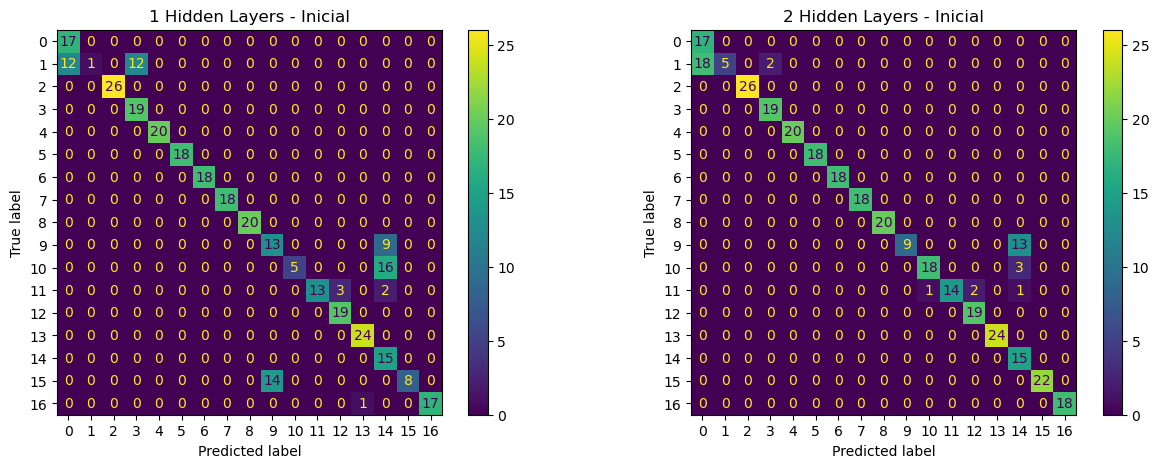

In [126]:
## plotando os resultados "iniciais"
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=[15,5])

print(score_def)

i = 0
for ax in axs:
    cm1 = confusion_matrix(y_te-1, np.argmax(y_nn_def[i],1))
    cmgraph1 = ConfusionMatrixDisplay(cm1)
    ax.set_title(f'{i+1} Hidden Layers - Inicial')
    cmgraph1.plot(ax=ax)

    
    i = i+1

[0.9941176176071167, 0.9941176176071167]


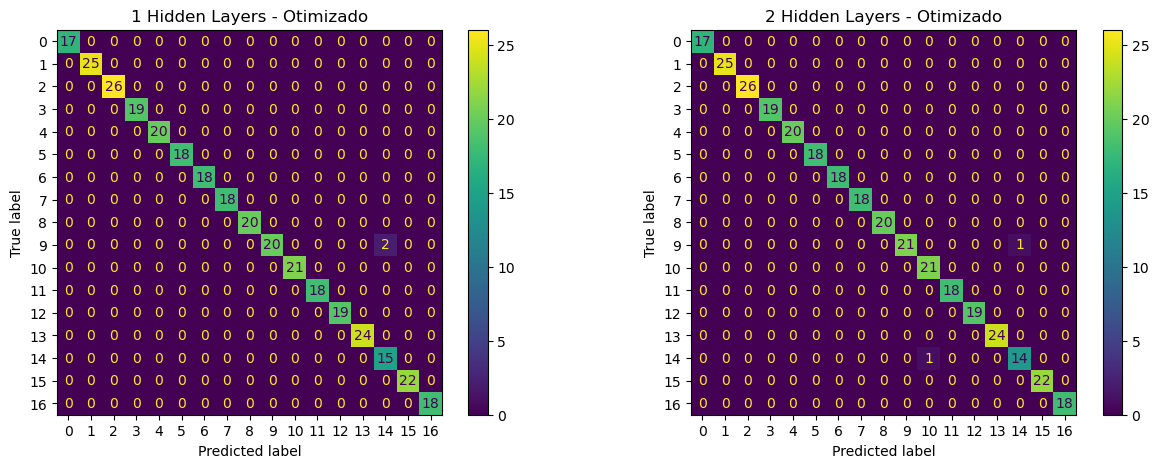

In [127]:
## plotando os resultados otimizados
b_sc = [best_score,best_score2]

print(b_sc)

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=[15,5])

y_nn = [best_model,best_model2,best_model3]

i = 0
for ax in axs:
    cm1 = confusion_matrix(y_te-1, np.argmax(y_nn[i],1))
    cmgraph1 = ConfusionMatrixDisplay(cm1)
    ax.set_title(f'{i+1} Hidden Layers - Otimizado')
    cmgraph1.plot(ax=ax)

    
    i = i+1

(0.0, 1.25)

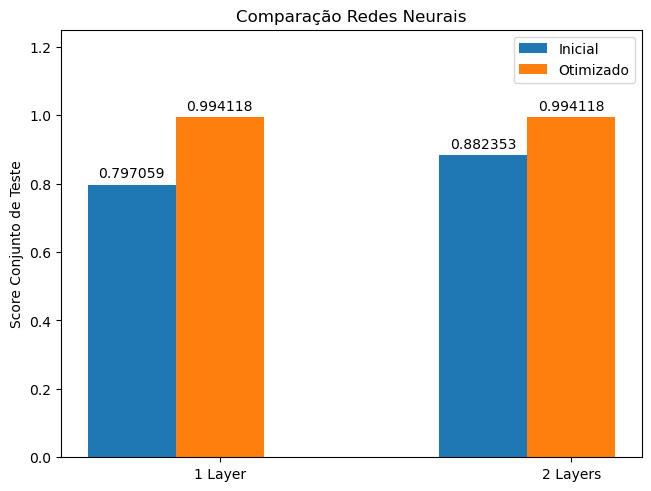

In [128]:
## plotando os scores

legenda = ["1 Layer","2 Layers"]
dados_plot = {"Inicial":score_def,
             "Otimizado":b_sc}

x = np.arange(len(legenda))  
width = 0.25  
multiplier = 0

fig,ax = plt.subplots(layout='constrained')

for tipo, valor in dados_plot.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, valor, width, label=tipo)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
ax.set_ylabel('Score Conjunto de Teste')
ax.set_title('Comparação Redes Neurais')
ax.set_xticks(x + width, legenda)
ax.legend()
ax.set_ylim(0, 1.25)



# 8 - Conclusões

Pode-se perceber que as redes neurais apresentam resultados excelentes. Após otimizar manualmente o número de neurônios, para o conjunto avaliado o desempenho foi idêntico (>0.99) para as 2 configurações de layers testadas. Com um número relativamente pequeno de epochs foi possível obter um ajuste de preditor melhor que a DecisionTree e RandomForest e equivalente aos obtidos pelo LogReg, KNN e SVC pós-tuning. Foi utilizado um validation_split de 0.2, early_stop atrelado ao "loss" e o melhor modelo foi escolhido com base no score do conjunto de validação, de forma que um ajuste mais fino dos parâmetros ou adição de layers provavelmente trariam um resultado ainda melhor para as redes, observando sempre a qualidade de generalização de predição para evitar overfitting.